In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.transforms import v2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [ ]:
!mkdir data

In [ ]:
# Baixa e extrai o dataset
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  1704k      0  0:00:06  0:00:06 --:--:-- 2534k
Archive:  data/animais.zip
   creating: data/animais/
   creating: data/animais/val/
   creating: data/animais/val/tatu/
  inflating: data/animais/val/tatu/10242.jpg  
  inflating: data/animais/val/tatu/10209.jpg  
  inflating: data/animais/val/tatu/10251.jpg  
  inflating: data/animais/val/tatu/10202.jpg  
  inflating: data/animais/val/tatu/10243.jpg  
  inflating: data/animais/val/tatu/10215.jpg  
  inflating: data/animais/val/tatu/10254.jpg  
  inflating: data/animais/val/tatu/10241.jpg  
  inflating: data/animais/val/tatu/10238.jpg  
  inflating: data/animais/val/tatu/10228.jpg  
  inflating: data/animais/val/tatu/10203.jpg  
  inflating: data/animais/val/tatu/10236.jpg  

In [ ]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

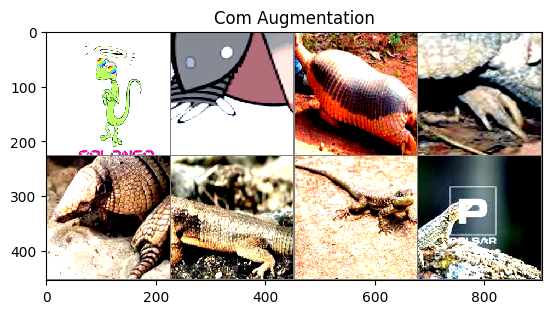

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


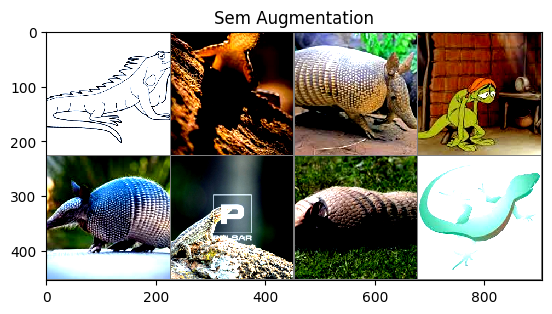

In [ ]:
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='none')
    if title is not None:
        plt.title(title)
    plt.show()

# Função para mostrar exemplos
def show_examples(loader, title):
    images, labels = next(iter(loader))
    images = images[:8]
    labels = labels[:8]
    imshow(torchvision.utils.make_grid(images, nrow=4), title)

# Mostrando exemplos com e sem data augmentation
show_examples(train_loader, title="Com Augmentation")
show_examples(val_loader, title="Sem Augmentation")

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 13 * 13, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0)
        x = x.view(-1, 16 * 13 * 13)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN(num_classes=2).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30)

100%|██████████| 13/13 [00:02<00:00,  4.68it/s]


Epoch 1, Train Loss: 0.693, Train Accuracy: 50.50%
Epoch 1, Val Loss: 0.692, Val Accuracy: 57.38%


100%|██████████| 13/13 [00:02<00:00,  5.76it/s]


Epoch 2, Train Loss: 0.693, Train Accuracy: 53.25%
Epoch 2, Val Loss: 0.685, Val Accuracy: 63.11%


100%|██████████| 13/13 [00:02<00:00,  5.69it/s]


Epoch 3, Train Loss: 0.691, Train Accuracy: 52.25%
Epoch 3, Val Loss: 0.684, Val Accuracy: 65.57%


100%|██████████| 13/13 [00:03<00:00,  4.29it/s]


Epoch 4, Train Loss: 0.688, Train Accuracy: 53.75%
Epoch 4, Val Loss: 0.678, Val Accuracy: 61.48%


100%|██████████| 13/13 [00:02<00:00,  5.53it/s]


Epoch 5, Train Loss: 0.687, Train Accuracy: 54.75%
Epoch 5, Val Loss: 0.668, Val Accuracy: 65.57%


100%|██████████| 13/13 [00:02<00:00,  5.69it/s]


Epoch 6, Train Loss: 0.681, Train Accuracy: 56.75%
Epoch 6, Val Loss: 0.660, Val Accuracy: 68.03%


100%|██████████| 13/13 [00:02<00:00,  5.64it/s]


Epoch 7, Train Loss: 0.677, Train Accuracy: 58.00%
Epoch 7, Val Loss: 0.645, Val Accuracy: 66.39%


100%|██████████| 13/13 [00:02<00:00,  4.65it/s]


Epoch 8, Train Loss: 0.675, Train Accuracy: 56.75%
Epoch 8, Val Loss: 0.636, Val Accuracy: 68.03%


100%|██████████| 13/13 [00:02<00:00,  5.62it/s]


Epoch 9, Train Loss: 0.665, Train Accuracy: 59.50%
Epoch 9, Val Loss: 0.616, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:02<00:00,  5.59it/s]


Epoch 10, Train Loss: 0.666, Train Accuracy: 61.25%
Epoch 10, Val Loss: 0.618, Val Accuracy: 69.67%


100%|██████████| 13/13 [00:02<00:00,  4.74it/s]


Epoch 11, Train Loss: 0.648, Train Accuracy: 61.00%
Epoch 11, Val Loss: 0.574, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:02<00:00,  5.38it/s]


Epoch 12, Train Loss: 0.650, Train Accuracy: 61.25%
Epoch 12, Val Loss: 0.601, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:02<00:00,  5.57it/s]


Epoch 13, Train Loss: 0.671, Train Accuracy: 59.75%
Epoch 13, Val Loss: 0.614, Val Accuracy: 76.23%


100%|██████████| 13/13 [00:02<00:00,  5.37it/s]


Epoch 14, Train Loss: 0.643, Train Accuracy: 62.75%
Epoch 14, Val Loss: 0.566, Val Accuracy: 76.23%


100%|██████████| 13/13 [00:03<00:00,  4.26it/s]


Epoch 15, Train Loss: 0.624, Train Accuracy: 64.00%
Epoch 15, Val Loss: 0.559, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:02<00:00,  5.48it/s]


Epoch 16, Train Loss: 0.632, Train Accuracy: 64.25%
Epoch 16, Val Loss: 0.593, Val Accuracy: 68.03%


100%|██████████| 13/13 [00:02<00:00,  5.61it/s]


Epoch 17, Train Loss: 0.650, Train Accuracy: 61.25%
Epoch 17, Val Loss: 0.604, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:02<00:00,  4.75it/s]


Epoch 18, Train Loss: 0.650, Train Accuracy: 61.50%
Epoch 18, Val Loss: 0.599, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:02<00:00,  5.07it/s]


Epoch 19, Train Loss: 0.638, Train Accuracy: 65.50%
Epoch 19, Val Loss: 0.558, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:02<00:00,  4.57it/s]


Epoch 20, Train Loss: 0.642, Train Accuracy: 61.75%
Epoch 20, Val Loss: 0.666, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:02<00:00,  5.47it/s]


Epoch 21, Train Loss: 0.668, Train Accuracy: 56.50%
Epoch 21, Val Loss: 0.599, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:03<00:00,  4.32it/s]


Epoch 22, Train Loss: 0.643, Train Accuracy: 63.25%
Epoch 22, Val Loss: 0.581, Val Accuracy: 77.05%


100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


Epoch 23, Train Loss: 0.620, Train Accuracy: 65.25%
Epoch 23, Val Loss: 0.549, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:02<00:00,  5.36it/s]


Epoch 24, Train Loss: 0.637, Train Accuracy: 64.50%
Epoch 24, Val Loss: 0.561, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


Epoch 25, Train Loss: 0.618, Train Accuracy: 64.75%
Epoch 25, Val Loss: 0.527, Val Accuracy: 78.69%


100%|██████████| 13/13 [00:02<00:00,  5.65it/s]


Epoch 26, Train Loss: 0.628, Train Accuracy: 67.50%
Epoch 26, Val Loss: 0.530, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:02<00:00,  5.48it/s]


Epoch 27, Train Loss: 0.617, Train Accuracy: 65.25%
Epoch 27, Val Loss: 0.544, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:02<00:00,  5.11it/s]


Epoch 28, Train Loss: 0.611, Train Accuracy: 65.25%
Epoch 28, Val Loss: 0.545, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:02<00:00,  4.50it/s]


Epoch 29, Train Loss: 0.615, Train Accuracy: 66.25%
Epoch 29, Val Loss: 0.592, Val Accuracy: 64.75%


100%|██████████| 13/13 [00:02<00:00,  5.71it/s]


Epoch 30, Train Loss: 0.625, Train Accuracy: 63.75%
Epoch 30, Val Loss: 0.543, Val Accuracy: 74.59%
Treinamento concluído


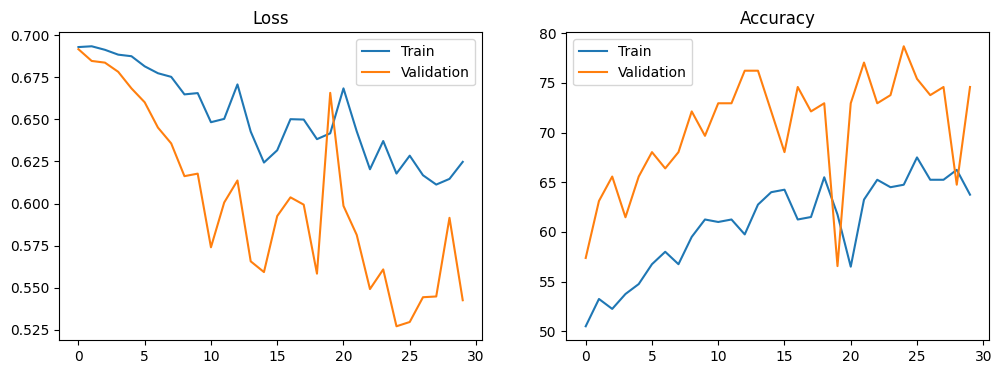

In [ ]:
plot_history(history)

## Exercícios

### Exercício 1
Quais transformações podem ser adicionadas ainda ao processo de data augmentation deste problema? Entre na documentação em https://pytorch.org/vision/stable/transforms.html e escolha, defina os parâmetros e treine novamente o modelo com no mínimo 3 novas transformações.

In [ ]:
# Carregando os datasets
transform_aug_2 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.v2.RandomGrayscale(0.25),
    transforms.v2.RandomRotation(30),
    transforms.v2.RandomPerspective(0.25),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug_2 = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug_2)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug_2)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [ ]:
model_2 = CNN(num_classes=2).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Treinando a CNN
history_2 = train_model(model_2, train_loader, val_loader, criterion, optimizer, device, num_epochs=30)

100%|██████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch 1, Train Loss: 0.695, Train Accuracy: 47.50%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.690, Val Accuracy: 54.92%


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Epoch 2, Train Loss: 0.698, Train Accuracy: 46.25%
Epoch 2, Val Loss: 0.688, Val Accuracy: 54.92%


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Epoch 3, Train Loss: 0.695, Train Accuracy: 50.25%
Epoch 3, Val Loss: 0.684, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


Epoch 4, Train Loss: 0.692, Train Accuracy: 53.00%
Epoch 4, Val Loss: 0.689, Val Accuracy: 59.02%


100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Epoch 5, Train Loss: 0.692, Train Accuracy: 56.25%
Epoch 5, Val Loss: 0.689, Val Accuracy: 59.84%


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


Epoch 6, Train Loss: 0.692, Train Accuracy: 51.00%
Epoch 6, Val Loss: 0.688, Val Accuracy: 59.84%


100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


Epoch 7, Train Loss: 0.690, Train Accuracy: 52.00%
Epoch 7, Val Loss: 0.686, Val Accuracy: 59.84%


100%|██████████| 13/13 [00:03<00:00,  3.61it/s]


Epoch 8, Train Loss: 0.690, Train Accuracy: 53.75%
Epoch 8, Val Loss: 0.676, Val Accuracy: 59.02%


100%|██████████| 13/13 [00:03<00:00,  4.08it/s]


Epoch 9, Train Loss: 0.702, Train Accuracy: 47.00%
Epoch 9, Val Loss: 0.686, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


Epoch 10, Train Loss: 0.688, Train Accuracy: 55.00%
Epoch 10, Val Loss: 0.680, Val Accuracy: 57.38%


100%|██████████| 13/13 [00:03<00:00,  3.46it/s]


Epoch 11, Train Loss: 0.690, Train Accuracy: 53.50%
Epoch 11, Val Loss: 0.677, Val Accuracy: 62.30%


100%|██████████| 13/13 [00:03<00:00,  4.08it/s]


Epoch 12, Train Loss: 0.686, Train Accuracy: 55.25%
Epoch 12, Val Loss: 0.679, Val Accuracy: 59.84%


100%|██████████| 13/13 [00:03<00:00,  4.12it/s]


Epoch 13, Train Loss: 0.679, Train Accuracy: 61.00%
Epoch 13, Val Loss: 0.663, Val Accuracy: 61.48%


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


Epoch 14, Train Loss: 0.689, Train Accuracy: 52.75%
Epoch 14, Val Loss: 0.660, Val Accuracy: 62.30%


100%|██████████| 13/13 [00:03<00:00,  4.10it/s]


Epoch 15, Train Loss: 0.691, Train Accuracy: 53.75%
Epoch 15, Val Loss: 0.677, Val Accuracy: 65.57%


100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


Epoch 16, Train Loss: 0.679, Train Accuracy: 58.25%
Epoch 16, Val Loss: 0.665, Val Accuracy: 62.30%


100%|██████████| 13/13 [00:03<00:00,  3.37it/s]


Epoch 17, Train Loss: 0.672, Train Accuracy: 58.75%
Epoch 17, Val Loss: 0.659, Val Accuracy: 59.02%


100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


Epoch 18, Train Loss: 0.676, Train Accuracy: 58.75%
Epoch 18, Val Loss: 0.680, Val Accuracy: 51.64%


100%|██████████| 13/13 [00:03<00:00,  4.25it/s]


Epoch 19, Train Loss: 0.682, Train Accuracy: 55.50%
Epoch 19, Val Loss: 0.661, Val Accuracy: 64.75%


100%|██████████| 13/13 [00:03<00:00,  3.60it/s]


Epoch 20, Train Loss: 0.673, Train Accuracy: 61.75%
Epoch 20, Val Loss: 0.631, Val Accuracy: 66.39%


100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


Epoch 21, Train Loss: 0.653, Train Accuracy: 63.00%
Epoch 21, Val Loss: 0.597, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:03<00:00,  4.08it/s]


Epoch 22, Train Loss: 0.667, Train Accuracy: 58.00%
Epoch 22, Val Loss: 0.572, Val Accuracy: 76.23%


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


Epoch 23, Train Loss: 0.651, Train Accuracy: 61.25%
Epoch 23, Val Loss: 0.634, Val Accuracy: 62.30%


100%|██████████| 13/13 [00:03<00:00,  4.30it/s]


Epoch 24, Train Loss: 0.690, Train Accuracy: 55.50%
Epoch 24, Val Loss: 0.615, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:03<00:00,  4.11it/s]


Epoch 25, Train Loss: 0.662, Train Accuracy: 59.50%
Epoch 25, Val Loss: 0.606, Val Accuracy: 77.05%


100%|██████████| 13/13 [00:03<00:00,  3.92it/s]


Epoch 26, Train Loss: 0.645, Train Accuracy: 62.25%
Epoch 26, Val Loss: 0.578, Val Accuracy: 71.31%


100%|██████████| 13/13 [00:03<00:00,  4.28it/s]


Epoch 27, Train Loss: 0.649, Train Accuracy: 62.50%
Epoch 27, Val Loss: 0.554, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


Epoch 28, Train Loss: 0.669, Train Accuracy: 59.75%
Epoch 28, Val Loss: 0.556, Val Accuracy: 77.05%


100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


Epoch 29, Train Loss: 0.637, Train Accuracy: 64.00%
Epoch 29, Val Loss: 0.569, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:03<00:00,  4.31it/s]


Epoch 30, Train Loss: 0.648, Train Accuracy: 65.00%
Epoch 30, Val Loss: 0.571, Val Accuracy: 74.59%
Treinamento concluído


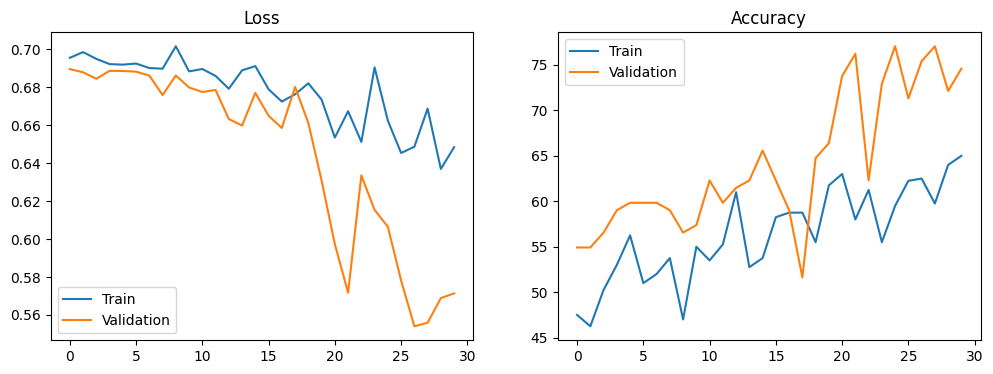

In [ ]:
plot_history(history_2)